In [3]:
%load_ext pycodestyle_magic
%flake8_on

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from Target_encoder import target_encoding
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report

pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 500)
np.random.seed(77)

# Chargement données

In [5]:
# chargement base de train
df_train = pd.read_csv(
    'train.csv', sep=',',
    low_memory=False,
    error_bad_lines=False)
df_train.drop("id", axis=1, inplace=True)
print(df_train.shape)

# chargement base de test
df_test = pd.read_csv(
    'test.csv', sep=',',
    low_memory=False,
    error_bad_lines=False)
print(df_test.shape)

(25000, 23)
(25000, 23)


# Description et analyse du dataset

In [6]:
df_train.target.value_counts(dropna=False)

0    12077
1     8816
2     3874
3      233
Name: target, dtype: int64

In [7]:
df_train.target.value_counts(normalize=True, dropna=False)

0    0.48308
1    0.35264
2    0.15496
3    0.00932
Name: target, dtype: float64

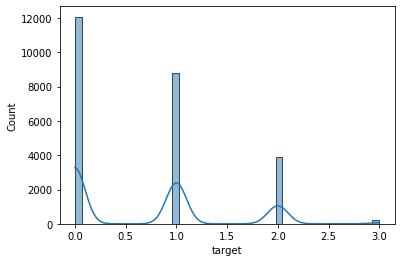

In [8]:
sns.histplot(df_train, x="target", kde=True)

In [9]:
df_train.dtypes

AP                       object
creation_date_answer     object
situation                 int64
ctc                      object
location                  int64
gc_id                     int64
gc_label                 object
creation_date_global     object
id_group                 object
id_group_2               object
favorite_fruit           object
fruit_situation_id        int64
fruit_situation_label    object
fruits_or_vegetables     object
number_of_fruit           int64
id_group_3               object
creation_date_request    object
hobby                    object
id_group_4               object
ville                    object
green_vegetables         object
vegetable_type           object
target                    int64
dtype: object

In [10]:
df_train.astype('object').describe().transpose()

,count,unique,top,freq
AP,25000,2,f,24914
creation_date_answer,25000,24278,2019-02-06 09:00:00,10
situation,25000,8,-1,23965
ctc,9620,2,f,8991
location,25000,99,70,1245
gc_id,25000,12,10,13813
gc_label,25000,12,A,13813
creation_date_global,25000,15680,2018-04-25 13:46:28.524,14
id_group,25000,15844,9eac919417ab0,14
id_group_2,25000,15675,12c9978a3bdfb,14


In [11]:
df_train.isnull().sum().sort_values(ascending = False)

vegetable_type           24586
fruits_or_vegetables     17341
ville                    16912
ctc                      15380
fruit_situation_label     1728
target                       0
id_group                     0
creation_date_answer         0
situation                    0
location                     0
gc_id                        0
gc_label                     0
creation_date_global         0
fruit_situation_id           0
id_group_2                   0
favorite_fruit               0
number_of_fruit              0
id_group_3                   0
creation_date_request        0
hobby                        0
id_group_4                   0
green_vegetables             0
AP                           0
dtype: int64

1:46: E251 unexpected spaces around keyword / parameter equals
1:48: E251 unexpected spaces around keyword / parameter equals


In [12]:
var = 'vegetable_type'
df_train.groupby(var)['target'].agg(['mean', 'count', 'std'])

,mean,count,std
vegetable_type,,,
almostgreen,0.000000,4,0.000000
green,0.832599,227,0.925640
notsogreen,1.171429,35,0.785370
prettygreen,1.300000,10,1.059350
salad,1.007519,133,0.941439
verygreen,1.000000,5,1.000000


In [13]:
df_train.vegetable_type.value_counts(normalize=True, dropna=False)

NaN            0.98344
green          0.00908
salad          0.00532
notsogreen     0.00140
prettygreen    0.00040
verygreen      0.00020
almostgreen    0.00016
Name: vegetable_type, dtype: float64

In [14]:
df_train.groupby('target').agg({'fruits_or_vegetables': 'value_counts'})

fruits_or_vegetables
target fruits_or_vegetables                      
0      f                                     3137
       t                                      619
1      f                                     2298
       t                                      415
2      f                                      918
       t                                      210
3      f                                       41
       t                                       21

# Nettoyage des données et création des features

## Gestion des  dates

In [15]:
# fonction pour parser une date
def parsing_date(df, column):
    
    df[f'day_{column}'] = df[column].dt.day
    df[f'week_{column}'] = df[column].dt.week
    df[f'month_{column}'] = df[column].dt.month
    df[f'year_{column}'] = df[column].dt.year
    df[f'hour_{column}'] = df[column].dt.hour
    df[f'weekday_{column}'] = df[column].dt.weekday
    return df

date_columns = [col for col in df_train.columns if "date" in col]

# fonction pour appliquer les transformations sur base de train et de test
def create_date_columns(df, columns):
    
    for date_col in columns:
        df[date_col] = pd.to_datetime(df[date_col])
        df = parsing_date(df, date_col)
        df.drop(date_col, axis=1, inplace=True)
    return df

df_test = create_date_columns(df_test, date_columns)
df_train = create_date_columns(df_train, date_columns)                    

3:1: W293 blank line contains whitespace
12:1: E305 expected 2 blank lines after class or function definition, found 1
15:1: E302 expected 2 blank lines, found 1
16:1: W293 blank line contains whitespace
23:1: E305 expected 2 blank lines after class or function definition, found 1


## Gestion des données catégorielles

In [16]:
# Identification des variables de type objet.
var_to_encode = df_train.select_dtypes(include=object).columns

In [17]:
var_to_encode

Index(['AP', 'ctc', 'gc_label', 'id_group', 'id_group_2', 'favorite_fruit', 'fruit_situation_label', 'fruits_or_vegetables', 'id_group_3', 'hobby', 'id_group_4', 'ville', 'green_vegetables', 'vegetable_type'], dtype='object')

In [18]:
df_train[var_to_encode].describe().T

,count,unique,top,freq
AP,25000,2,f,24914
ctc,9620,2,f,8991
gc_label,25000,12,A,13813
id_group,25000,15844,9eac919417ab0,14
id_group_2,25000,15675,12c9978a3bdfb,14
favorite_fruit,25000,2,clementine,18147
fruit_situation_label,23272,21,ag,10651
fruits_or_vegetables,7659,2,f,6394
id_group_3,25000,872,fa2eb9a81317a,298
hobby,25000,3,football,24661


#  Encoding

In [19]:
var_to_encode_describe = df_train[var_to_encode].describe().T

In [20]:
# Recuperer dans un objet les noms de variables.
# pour lesquelles un one hot encoding sera appliqué
var_to_one_hot = var_to_encode_describe[var_to_encode_describe.unique <= 3].index

In [21]:
# Gestion des données manquantes avec un fillna par la modalité missing.
# Le ohe créera une colonne specifique pour les données manquantes.
# Un modele peut extraire de l'information sur des données non renseignés.

df_train[var_to_one_hot] = df_train[var_to_one_hot].fillna("missing")
df_test[var_to_one_hot] = df_test[var_to_one_hot].fillna("missing")

## One hot encoding

In [22]:
# Application du ohe
drop_enc = OneHotEncoder().fit(df_train[var_to_one_hot])

df_train_ohe = drop_enc.transform(df_train[var_to_one_hot])
df_test_ohe = drop_enc.transform(df_test[var_to_one_hot])

In [23]:
# Transformation de la matrice en format dataframe
# concatenation des colonnes encodées
# Suppression des variables originales

df_train.drop(var_to_one_hot, axis=1, inplace=True)

df_train_ohe = pd.concat([pd.DataFrame.sparse.from_spmatrix
                          (df_train_ohe,
                           columns=drop_enc.get_feature_names_out()),
                           df_train],
                        axis=1)

df_test.drop(var_to_one_hot, axis=1, inplace=True)

df_test_ohe = pd.concat([pd.DataFrame.sparse.from_spmatrix
                         (df_test_ohe, 
                        columns=drop_enc.get_feature_names_out()),
                        df_test], axis=1)




10:28: E127 continuation line over-indented for visual indent
11:25: E128 continuation line under-indented for visual indent
16:39: W291 trailing whitespace
17:25: E128 continuation line under-indented for visual indent


In [24]:
# resultat du one hot encoding
df_train_ohe

,AP_f,AP_t,ctc_f,ctc_missing,ctc_t,favorite_fruit_clementine,favorite_fruit_poire,fruits_or_vegetables_f,fruits_or_vegetables_missing,fruits_or_vegetables_t,hobby_football,hobby_noball,hobby_volleyball,green_vegetables_f,green_vegetables_t,situation,location,gc_id,gc_label,id_group,id_group_2,fruit_situation_id,fruit_situation_label,number_of_fruit,id_group_3,id_group_4,ville,vegetable_type,target,day_creation_date_answer,week_creation_date_answer,month_creation_date_answer,year_creation_date_answer,hour_creation_date_answer,weekday_creation_date_answer,day_creation_date_global,week_creation_date_global,month_creation_date_global,year_creation_date_global,hour_creation_date_global,weekday_creation_date_global,day_creation_date_request,week_creation_date_request,month_creation_date_request,year_creation_date_request,hour_creation_date_request,weekday_creation_date_request
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-1,52,70,G,2d7e206d46ea1,36bac09400660,120,jzy,-1,812a43d710ace,aa8f4934a31eb,NaN,NaN,0,13,11,3,2019,11,2,17,3,1,2019,10,3,13,11,3,2019,11,2
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-1,78,10,A,35e96d6848871,80a697d593706,10,ae,-1,4b59257f24573,6ff9ea9ec85fd,NaN,NaN,1,21,12,3,2019,14,3,20,34,8,2018,5,0,21,12,3,2019,14,3
2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-1,70,10,A,ffaf8085e383d,c309176b96268,200,ag,-1,f1a838f0d194b,6a49a0a97b049,NaN,NaN,0,15,11,3,2019,17,4,20,51,12,2018,13,3,15,11,3,2019,17,4
3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-1,84,10,A,5360cf0a40ce3,13c1a3597648b,10,ae,0,c3196847d1c14,d0dcf1ca1bf04,NaN,NaN,1,7,2,1,2019,8,0,21,29,7,2018,10,5,7,2,1,2019,8,0
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-1,29,20,D,126c3211f23fc,7b68e0a456571,10,ae,-1,70e18c6fe58cd,b4870b1c8eb42,NaN,NaN,1,3,5,2,2019,17,6,7,49,12,2018,19,4,3,5,2,2019,17,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-1,17,10,A,07d568301bae5,8ed90715244e0,160,zht,-1,7f9b9fe72ad1b,97de0f5d0b0cf,NaN,NaN,0,21,12,3,2019,16,3,16,11,3,2019,10,5,21,12,3,2019,16,3
24996,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-1,93,10,A,ecf26c2e00203,5f820a5b9c8cd,10,ae,-1,5918a05e76cfe,0aac6e868db10,NaN,NaN,1,15,7,2,2019,21,4,15,37,9,2018,9,5,15,7,2,2019,21,4
24997,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-1,68,10,A,c84066a550a3a,6532597956225,200,ag,0,50101f6881261,89c8a90e0ce38,NaN,NaN,0,3,1,1,2019,10,3,20,38,9,2018,13,3,3,1,1,2019,10,3
24998,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,-1,78,20,D,98e8126974bad,8aa3d8d3a97d3,200,ag,0,0f1a3e137c5ea,0157899906f02,Moissy-Cramayel,NaN,1,17,3,1,2019,12,3,4,44,11,2018,17,6,17,3,1,2019,12,3


In [25]:
# passage de la variable id en index, car ne doit pas être encoder
df_test_ohe = df_test_ohe.set_index('id')


## Target encoding

In [26]:
var_to_te = var_to_encode_describe[var_to_encode_describe.unique > 3].index

In [27]:
var_to_te

Index(['gc_label', 'id_group', 'id_group_2', 'fruit_situation_label', 'id_group_3', 'id_group_4', 'ville', 'vegetable_type'], dtype='object')

# Exemple sur une variable à encoder

In [28]:
prior = df_train.target.mean()
print('Prior (moyenne de la cible à prédire) =', prior)

var = 'gc_label'
df_train.groupby(var)['target'].agg(['mean', 'count', 'std'])

Prior (moyenne de la cible à prédire) = 0.69052


,mean,count,std
gc_label,,,
A,0.644321,13813,0.699465
B,0.912796,2282,0.927359
C,0.506329,948,0.705209
D,0.756357,3854,0.756359
E,0.856209,153,0.764494
F,0.461538,13,0.776250
G,0.487619,525,0.684018
H,0.750674,2226,0.874771
I,0.676829,164,0.813505


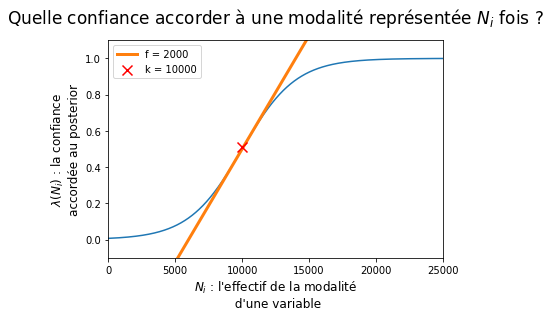

4:37: E128 continuation line under-indented for visual indent
5:37: E128 continuation line under-indented for visual indent
6:37: E128 continuation line under-indented for visual indent
7:37: E128 continuation line under-indented for visual indent
8:37: E128 continuation line under-indented for visual indent
9:37: E128 continuation line under-indented for visual indent


In [29]:
# Application de la fonction target encoding

encoding_gc_label, mapping_gc_label = target_encoding(df_train,
                                    serie='gc_label',
                                    target_name='target',
                                    k=10000,
                                    f=2000,
                                    avec_viz=True,
                                    noise_level=0)

In [30]:
# resultat de l'encoding
mapping_gc_label

{'A': 0.6502975992746985,
 'B': 0.6951107763128783,
 'C': 0.6885476870940799,
 'D': 0.6934322892265472,
 'E': 0.6917164587368099,
 'F': 0.6889775340693239,
 'G': 0.6887579188690934,
 'H': 0.6917287734642878,
 'I': 0.6904205965086627,
 'J': 0.685893859698352,
 'K': 0.6903641430867458,
 'L': 0.6906857716546099,
 nan: 0.69052}

In [31]:
te_mapping = {}

for var in var_to_te:
    encoding, mapping = target_encoding(df_train, serie=var,
                                        target_name='target',
                                        k = 10000,
                                        f = 2000,
                                        avec_viz=False, noise_level=0)
    te_mapping[var]= mapping

6:42: E251 unexpected spaces around keyword / parameter equals
6:44: E251 unexpected spaces around keyword / parameter equals
7:42: E251 unexpected spaces around keyword / parameter equals
7:44: E251 unexpected spaces around keyword / parameter equals
9:20: E225 missing whitespace around operator


In [32]:
def build_df_encoding(df, te_mapping):
    for var, mapping in te_mapping.items():
        df[var] = df[var].map(mapping)
    return df

In [33]:
df_train_te = build_df_encoding(df_train_ohe, te_mapping)
df_test_te = build_df_encoding(df_test_ohe, te_mapping)

In [34]:
print(df_train_te.shape)
print(df_test_te.shape)

(25000, 47)
(25000, 46)


In [35]:
df_train_te.head(3)

,AP_f,AP_t,ctc_f,ctc_missing,ctc_t,favorite_fruit_clementine,favorite_fruit_poire,fruits_or_vegetables_f,fruits_or_vegetables_missing,fruits_or_vegetables_t,hobby_football,hobby_noball,hobby_volleyball,green_vegetables_f,green_vegetables_t,situation,location,gc_id,gc_label,id_group,id_group_2,fruit_situation_id,fruit_situation_label,number_of_fruit,id_group_3,id_group_4,ville,vegetable_type,target,day_creation_date_answer,week_creation_date_answer,month_creation_date_answer,year_creation_date_answer,hour_creation_date_answer,weekday_creation_date_answer,day_creation_date_global,week_creation_date_global,month_creation_date_global,year_creation_date_global,hour_creation_date_global,weekday_creation_date_global,day_creation_date_request,week_creation_date_request,month_creation_date_request,year_creation_date_request,hour_creation_date_request,weekday_creation_date_request
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-1,52,70,0.688758,0.685894,0.685894,120,0.686462,-1,0.685869,0.685894,0.69052,0.69052,0,13,11,3,2019,11,2,17,3,1,2019,10,3,13,11,3,2019,11,2
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-1,78,10,0.650298,0.692594,0.692594,10,0.751629,-1,0.687839,0.692594,0.69052,0.69052,1,21,12,3,2019,14,3,20,34,8,2018,5,0,21,12,3,2019,14,3
2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-1,70,10,0.650298,0.685892,0.685892,200,0.508120,-1,0.687776,0.685892,0.69052,0.69052,0,15,11,3,2019,17,4,20,51,12,2018,13,3,15,11,3,2019,17,4


# Modelisation

In [37]:
# split train test
X = df_train_te.drop('target', axis=1)
y = df_train_te.target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 77, stratify=y)

6:68: E251 unexpected spaces around keyword / parameter equals
6:70: E251 unexpected spaces around keyword / parameter equals
6:88: E251 unexpected spaces around keyword / parameter equals
6:90: E251 unexpected spaces around keyword / parameter equals


## Random Forest classifier

In [38]:
rfc=RandomForestClassifier(random_state = 77)

1:4: E225 missing whitespace around operator
1:40: E251 unexpected spaces around keyword / parameter equals
1:42: E251 unexpected spaces around keyword / parameter equals


In [45]:
%%time

#param_grid ={
#    'n_estimators': [500,800,1000],
#    'max_features':['auto'],
#    'max_depth':[5 ,8, 10, 12],
#    'criterion':['gini']

#}

param_grid ={
    'n_estimators': [1000],
    'max_features':['auto'],
    'max_depth':[12],
    'criterion':['gini']

}
#cv_rfc = GridSearchCV(rfc, param_grid,cv=10, scoring='neg_log_loss',verbose=1)

cv_rfc = RandomizedSearchCV(estimator=rfc,
                         param_distributions=param_grid,
                         scoring='neg_log_loss',
                         n_iter=5,
                         verbose=1,)





CPU times: user 19 µs, sys: 1 µs, total: 20 µs
Wall time: 23.8 µs


In [43]:
cv_rfc 

RandomizedSearchCV(estimator=RandomForestClassifier(random_state=77), n_iter=5,
                   param_distributions={'criterion': ['gini'],
                                        'max_depth': [5, 8, 10, 12],
                                        'max_features': ['auto'],
                                        'n_estimators': [500, 800, 1000]},
                   scoring='neg_log_loss', verbose=1)

In [46]:
%%time
cv_rfc.fit(X_train,y_train, sample_weight=10**y_train )

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:625: UserWarning: pandas.Data

CPU times: user 1min 26s, sys: 1.25 s, total: 1min 27s
Wall time: 1min 28s


RandomizedSearchCV(estimator=RandomForestClassifier(random_state=77), n_iter=5,
                   param_distributions={'criterion': ['gini'],
                                        'max_depth': [12],
                                        'max_features': ['auto'],
                                        'n_estimators': [1000]},
                   scoring='neg_log_loss', verbose=1)

In [47]:
cv_rfc.best_params_

{'n_estimators': 1000,
 'max_features': 'auto',
 'max_depth': 12,
 'criterion': 'gini'}

In [48]:
cv_rfc.best_estimator_

RandomForestClassifier(max_depth=12, n_estimators=1000, random_state=77)

In [51]:

rfc1=RandomForestClassifier(random_state=77, **cv_rfc.best_params_)

2:5: E225 missing whitespace around operator


In [52]:
rfc1.fit(X_train, y_train, sample_weight=10**y_train )

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


RandomForestClassifier(max_depth=12, n_estimators=1000, random_state=77)

1:53: E202 whitespace before ')'


In [53]:
pred_rfc = rfc1.predict(X_test)
preds_rfc_prob = rfc1.predict_proba(X_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


In [54]:

print(classification_report(pred_rfc, y_test))

              precision    recall  f1-score   support

           0       0.35      0.98      0.51       854
           1       0.66      0.70      0.68      1640
           2       0.93      0.29      0.44      2484
           3       0.17      0.36      0.23        22

    accuracy                           0.54      5000
   macro avg       0.53      0.58      0.47      5000
weighted avg       0.74      0.54      0.53      5000



In [58]:
print("log loss pour RF classifier sur train:", log_loss(y_test, preds_rfc_prob))

log loss pour RF classifier sur train: 1.0261444717347372


In [57]:
confusion_matrix(pred_rfc, y_test)

array([[ 839,   11,    4,    0],
       [ 439, 1155,   44,    2],
       [1135,  593,  719,   37],
       [   2,    4,    8,    8]])

In [59]:
def plot_feature_importance(df,model):
    
    importances = model.best_estimator_.feature_importances_
    print()
    std = np.std([tree.feature_importances_ for tree in model.best_estimator_.estimators_],axis=0)
    indices = np.argsort(importances)[::-1]
    print(len(indices))
    print(len(df.columns))
    names = [df.columns[i] for i in indices]
    
    # Print the feature ranking
    
    print("Feature ranking:")
    for f in range(X_test.shape[1]):
        print("%d. feature name: %s (%f)" % (f + 1, names[f], importances[indices[f]]))
        
    # Plot the feature importances of the forest
    plt.figure(figsize=(16,12))
    plt.title("Feature importances")
    plt.bar(range(df.shape[1]), importances[indices],color="r", yerr=std[indices], align="center")
    plt.xticks(range(df.shape[1]), names, rotation=90)
    plt.xlim([-1,df.shape[1]])
    return plt.show()

1:31: E231 missing whitespace after ','
2:1: W293 blank line contains whitespace
5:80: E501 line too long (98 > 79 characters)
5:91: E231 missing whitespace after ','
10:1: W293 blank line contains whitespace
12:1: W293 blank line contains whitespace
15:80: E501 line too long (87 > 79 characters)
16:1: W293 blank line contains whitespace
18:27: E231 missing whitespace after ','
20:53: E231 missing whitespace after ','
20:80: E501 line too long (98 > 79 characters)
22:17: E231 missing whitespace after ','



46
46
Feature ranking:
1. feature name: location (0.123418)
2. feature name: id_group_3 (0.083700)
3. feature name: id_group_4 (0.061332)
4. feature name: id_group (0.061122)
5. feature name: id_group_2 (0.061093)
6. feature name: week_creation_date_global (0.045752)
7. feature name: day_creation_date_global (0.038637)
8. feature name: hour_creation_date_answer (0.035005)
9. feature name: hour_creation_date_request (0.034187)
10. feature name: hour_creation_date_global (0.032175)
11. feature name: month_creation_date_global (0.032024)
12. feature name: day_creation_date_request (0.031403)
13. feature name: fruit_situation_id (0.030072)
14. feature name: day_creation_date_answer (0.030033)
15. feature name: fruit_situation_label (0.029784)
16. feature name: weekday_creation_date_global (0.025467)
17. feature name: weekday_creation_date_request (0.024799)
18. feature name: weekday_creation_date_answer (0.024700)
19. feature name: ville (0.023381)
20. feature name: week_creation_date_ans

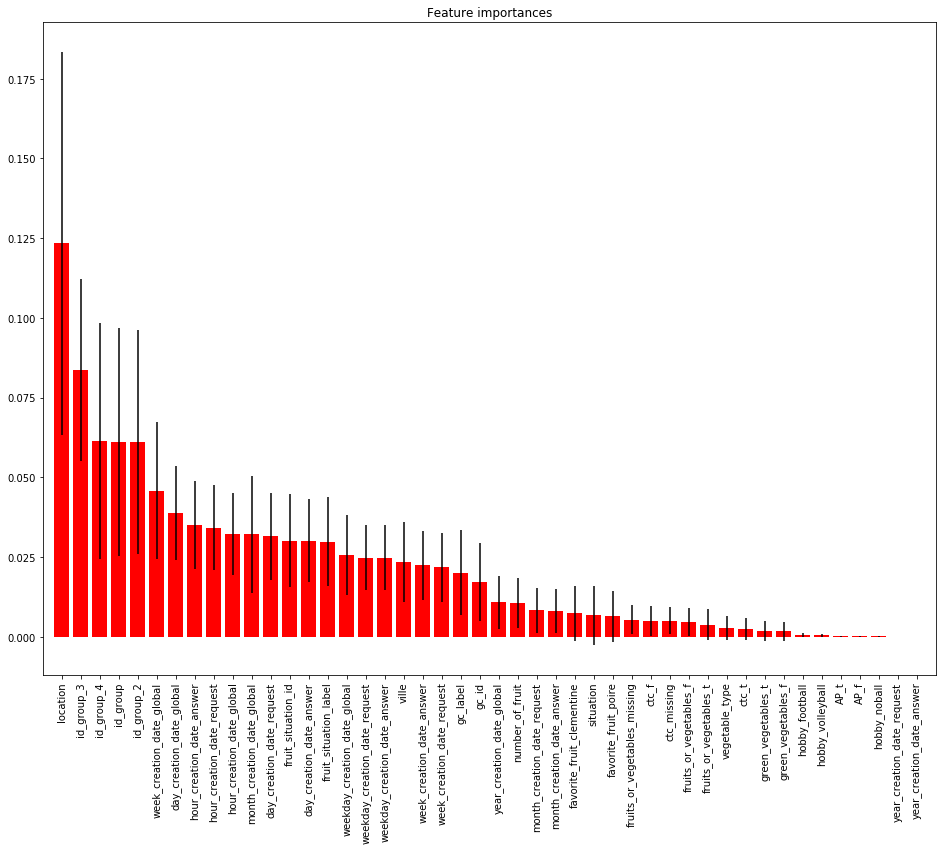

In [61]:
plot_feature_importance(X_train, cv_rfc)

# Modele 2 : Xgboost classifieur

In [81]:

xgbc = XGBClassifier(objective="multi:softprob", seed=77)

#param_grid_xgb = {
#    'max_depth': [8 ,10,12],
#    'n_estimators': [1000, 1200],
#    'learning_rate': [0.1, 0.3, 0,01]
    
#}

param_grid_xgb = {
    'max_depth': [8],
    'n_estimators': [1200],
    'learning_rate': [0.1]
    
}



4:1: E265 block comment should start with '# '
8:1: W293 blank line contains whitespace
9:1: E265 block comment should start with '# '
15:1: W293 blank line contains whitespace


In [22]:
#grid_xgb = GridSearchCV(estimator=xgbc,param_grid=param_grid_xgb,scoring='neg_log_loss',cv = 10,verbose=True, n_jobs = -1)

In [ ]:
#%%time
#grid_xgb.fit(X_train,y_train, sample_weight=10**y_train )


In [82]:
cv_clf = RandomizedSearchCV(estimator=xgbc,
                         param_distributions=param_grid_xgb,
                         scoring='neg_log_loss',
                         #n_iter=5,
                         verbose=1,
                        )

2:26: E128 continuation line under-indented for visual indent
3:26: E128 continuation line under-indented for visual indent
4:26: E128 continuation line under-indented for visual indent
4:26: E265 block comment should start with '# '
5:26: E128 continuation line under-indented for visual indent
6:25: E124 closing bracket does not match visual indentation


In [83]:
%%time
cv_clf.fit(X_train,y_train, sample_weight=10**y_train )

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: user 1h 14min 1s, sys: 42.5 s, total: 1h 14min 43s
Wall time: 10min 23s


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,
                                           max_c...
                                           max_delta_step=None, max_depth=None,
                                  

In [84]:
cv_clf.best_params_

{'n_estimators': 1200, 'max_depth': 8, 'learning_rate': 0.1}

In [85]:
xgbc1 = XGBClassifier(objective="multi:softprob", seed=77, **cv_clf.best_params_) # multi:softmax

1:82: E261 at least two spaces before inline comment


In [86]:
xgbc1.fit(X_train, y_train, sample_weight=10**y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1200,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=77, reg_alpha=0, ...)

In [87]:
pred_xgb = xgbc1.predict(X_test)
preds_xgb_prob = xgbc1.predict_proba(X_test)

In [88]:
print("log loss pour Xgboost classifier sur train: ", log_loss(y_test, preds_xgb_prob))

log loss pour Xgboost classifier sur train:  0.8673895631085335


In [89]:

confusion_matrix(pred_xgb, y_test)

array([[1863,  246,   91,    8],
       [ 372, 1381,  135,    7],
       [ 178,  128,  542,   22],
       [   2,    8,    7,   10]])

In [90]:
print(classification_report(pred_xgb, y_test))

              precision    recall  f1-score   support

           0       0.77      0.84      0.81      2208
           1       0.78      0.73      0.76      1895
           2       0.70      0.62      0.66       870
           3       0.21      0.37      0.27        27

    accuracy                           0.76      5000
   macro avg       0.62      0.64      0.62      5000
weighted avg       0.76      0.76      0.76      5000



In [95]:
def plot_feature_importance_xgb(data, model):
    sorted_idx = model.feature_importances_.argsort()
    plt.figure(figsize=(16, 12))
    plt.barh(data.columns[sorted_idx], model.feature_importances_[sorted_idx])
    plt.xlabel("Xgboost Feature Importance")
    return plt.show()

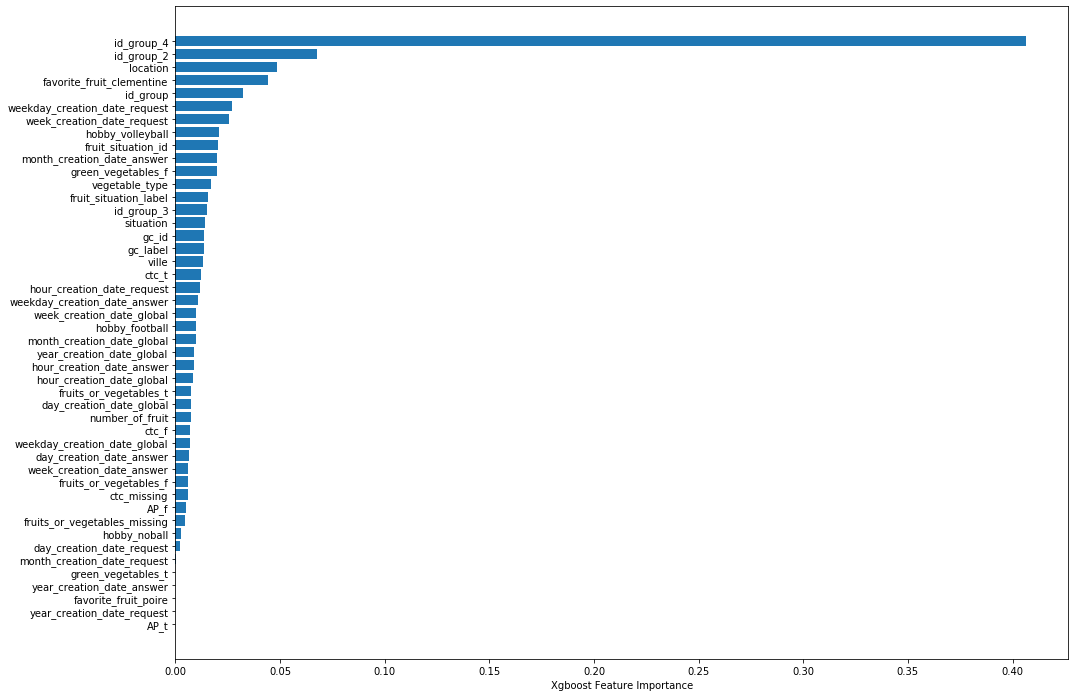

In [96]:
plot_feature_importance_xgb(X_train, xgbc1)

# Predict sur test

In [98]:
predict_train = xgbc1.predict_proba(df_test_te)


In [108]:
df_test_te

,AP_f,AP_t,ctc_f,ctc_missing,ctc_t,favorite_fruit_clementine,favorite_fruit_poire,fruits_or_vegetables_f,fruits_or_vegetables_missing,fruits_or_vegetables_t,hobby_football,hobby_noball,hobby_volleyball,green_vegetables_f,green_vegetables_t,situation,location,gc_id,gc_label,id_group,id_group_2,fruit_situation_id,fruit_situation_label,number_of_fruit,id_group_3,id_group_4,ville,vegetable_type,day_creation_date_answer,week_creation_date_answer,month_creation_date_answer,year_creation_date_answer,hour_creation_date_answer,weekday_creation_date_answer,day_creation_date_global,week_creation_date_global,month_creation_date_global,year_creation_date_global,hour_creation_date_global,weekday_creation_date_global,day_creation_date_request,week_creation_date_request,month_creation_date_request,year_creation_date_request,hour_creation_date_request,weekday_creation_date_request
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cb7a4e0dd0777,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,30,100,40,0.695111,NaN,NaN,120,0.686462,1,0.689312,NaN,0.685889,0.690520,13,11,3,2019,7,2,13,11,3,2019,7,2,13,11,3,2019,7,2
e78e3915f3e30,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,-1,95,40,0.695111,0.695943,0.695943,50,0.706915,1,0.694196,0.695943,0.690957,0.690520,7,2,1,2019,13,0,18,51,12,2018,18,1,7,2,1,2019,13,0
8e65ba155f983,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-1,34,20,0.693432,NaN,NaN,200,0.508120,-1,0.686721,NaN,0.686266,0.690520,25,4,1,2019,14,4,17,3,1,2018,13,2,25,4,1,2019,14,4
701e90ca03ce2,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,10,45,40,0.695111,0.685894,0.685894,200,0.508120,2,0.688050,0.685894,0.685894,0.690520,16,3,1,2019,14,2,7,45,11,2018,13,2,16,3,1,2019,14,2
768fefec8609a,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,10,95,100,0.691729,NaN,NaN,50,0.706915,2,0.696938,NaN,0.685871,0.690520,11,7,2,2019,14,0,16,42,10,2018,10,1,11,7,2,2019,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3232bad9c00cc,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-1,60,10,0.650298,0.690520,0.690520,200,0.508120,0,0.685615,0.690520,0.690520,0.690520,11,7,2,2019,9,0,8,6,2,2019,15,4,11,7,2,2019,9,0
7b178c38ad263,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-1,45,10,0.650298,0.690520,0.690520,200,0.508120,-1,0.688050,0.690520,0.688054,0.690520,23,4,1,2019,9,2,18,51,12,2018,11,1,23,4,1,2019,9,2
5876ad905d4b4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-1,58,10,0.650298,0.690520,0.690520,10,0.751629,-1,0.687479,0.690520,0.690520,0.690520,10,10,3,2019,7,6,27,9,2,2019,11,2,10,10,3,2019,7,6


In [109]:
df_pred_train = pd.concat([pd.DataFrame(df_test_te.index),
                     pd.DataFrame(predict_train)],
                    axis=1)

2:22: E128 continuation line under-indented for visual indent
3:21: E128 continuation line under-indented for visual indent


In [110]:
df_pred_train

,id,0,1,2,3
0,cb7a4e0dd0777,0.999483,0.000517,6.529125e-09,1.658142e-09
1,e78e3915f3e30,0.000133,0.972037,2.780657e-02,2.341822e-05
2,8e65ba155f983,0.999995,0.000005,1.783282e-08,1.264612e-10
3,701e90ca03ce2,0.999995,0.000004,3.404137e-07,7.789070e-09
4,768fefec8609a,0.999995,0.000001,1.280887e-06,2.270629e-06
...,...,...,...,...,...
24995,3232bad9c00cc,0.997279,0.000231,2.442969e-03,4.749723e-05
24996,7b178c38ad263,0.184919,0.044436,7.706341e-01,1.087935e-05
24997,5876ad905d4b4,0.002254,0.997745,4.836485e-07,3.590272e-07
24998,5921ef2921c68,0.999994,0.000006,2.167044e-09,9.040671e-09


In [111]:
df_pred_train.to_csv('resultat_test.csv')

# Conclusion

## Ouverture